In [859]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.signal import savgol_filter

In [860]:
# Import files
geophysical_data = pd.read_csv('SourceData_Fig2/112_geophysical_sections.csv')
locations =pd.read_csv('SourceData_Fig2/112_location.csv')

In [861]:
#Coords and values
x = geophysical_data['x'].values
geophysical_data['z'] = geophysical_data['z']*-1 #Invert depth values
y = geophysical_data['z'].values
Vp_values = geophysical_data['Vp'].values
serp_values = geophysical_data['Serp_Degree'].values
# Grid creation
x_unique = np.unique(x)
y_unique = np.unique(y)
X, Y = np.meshgrid(x_unique, y_unique)
Z = np.empty(X.shape) #Vp grid
Z2 = np.empty(X.shape) #Serpentinization grid
Z[:] = np.nan 
Z2[:] = np.nan  
#Vp Grid
for i in range(len(x)):
    x_index = np.where(x_unique == x[i])[0][0]
    y_index = np.where(y_unique == y[i])[0][0]
    Z[y_index, x_index] = Vp_values[i]
#Serpentinization Grid
for i in range(len(x)):
    x_index = np.where(x_unique == x[i])[0][0]
    y_index = np.where(y_unique == y[i])[0][0]
    Z2[y_index, x_index] = serp_values[i]

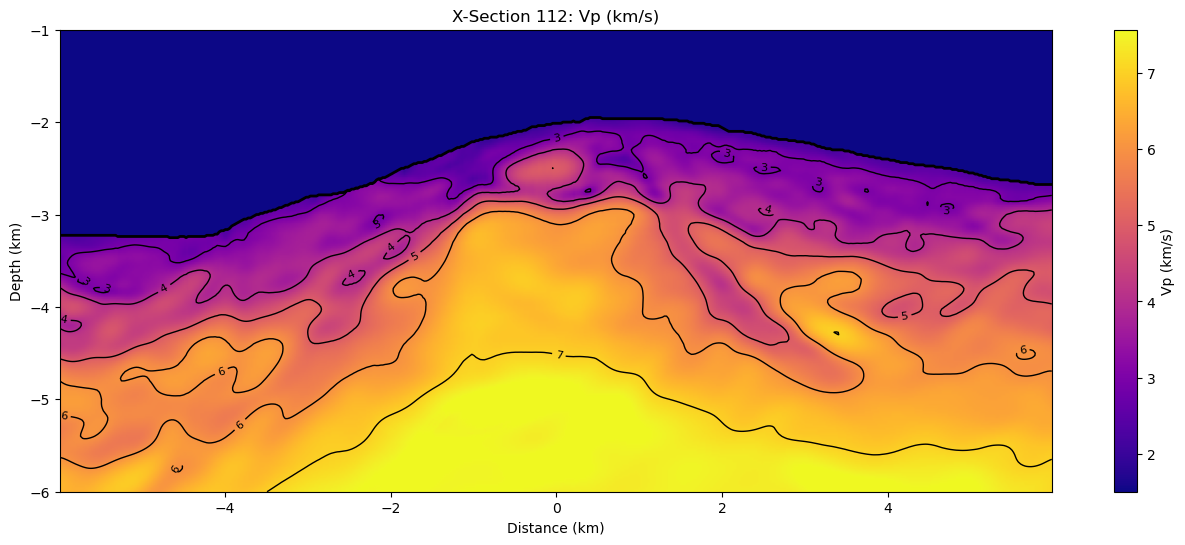

In [862]:
#Vp image + contours
fig, ax = plt.subplots(figsize=(16, 6))
im = ax.imshow(
    Z,
    cmap='plasma',
    extent=[x_unique.min(), x_unique.max(), y_unique.min(), y_unique.max()],
    origin='lower',
    aspect='auto'
)
contours = ax.contour(
    X, Y, Z,
    levels=[3,4,5,6,7,8],               
    colors='k',              
    linewidths=1,
    extent=[x_unique.min(), x_unique.max(), y_unique.min(), y_unique.max()]
)
ax.clabel(contours, inline=True, fontsize=8) 
locations['bathymetry']=locations['bathymetry']*-1
fig.colorbar(im, ax=ax, label='Vp (km/s)')
ax.plot(locations['x'], locations['bathymetry'], color='black', linewidth=2, label='Bathymetry')
ax.set_xlabel('Distance (km)')
ax.set_ylabel('Depth (km)')
ax.set_title('X-Section 112: Vp (km/s)')
plt.show()
# Extract contour line for Vp = 7
coords = contours.allsegs[4]
all_points = []
for arr in coords:
    for x, y in arr:
        all_points.append({'x': x, 'y': y})
contour_geophysical_data = pd.DataFrame(all_points)

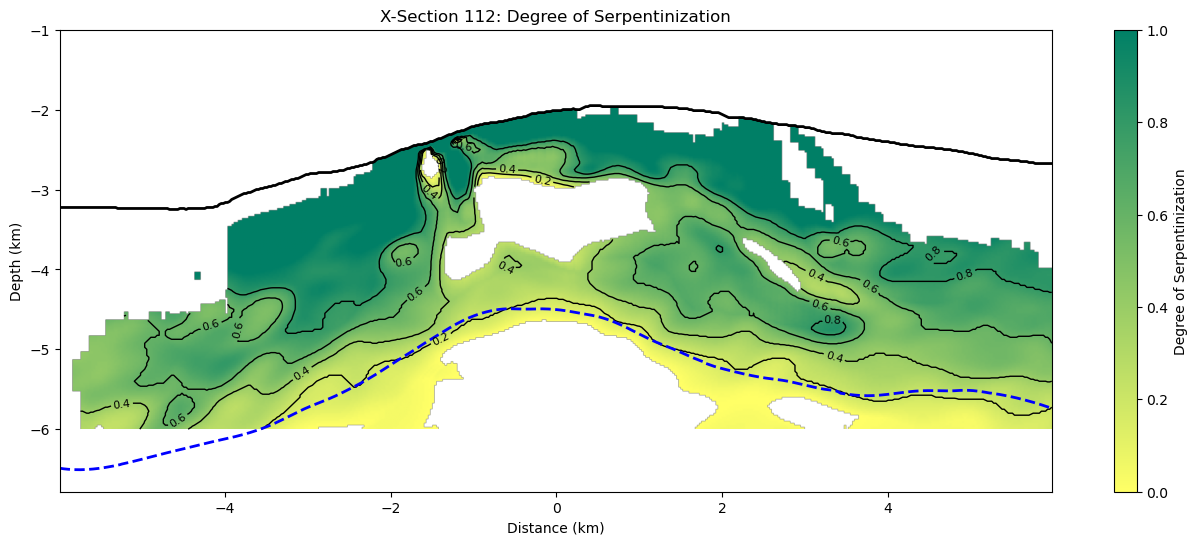

In [863]:
# Degree of serpentinization image
contour_full = pd.merge(locations, contour_geophysical_data, on='x', how='left')
#Smooth out contour lines and interpolate missing values
contour_full.loc[0:20,'y'] = -6.5
contour_full[contour_full['y'] >-4.45] = None  
contour_full['interpolated_y'] = contour_full['y'].interpolate(method='linear', limit_direction='both')
contour_full['high_Vp'] = savgol_filter(contour_full['interpolated_y'], window_length=60, polyorder=3)
contour_full = contour_full[contour_full['x'].notnull()]
fig2, ax2 =plt.subplots(figsize=(16, 6))
contours_serp = ax2.contour(
    X, Y, Z2,
    levels=[0.2,0.4,0.6,0.8,1.0],               
    colors='k',              
    linewidths=1,
    extent=[x_unique.min(), x_unique.max(), y_unique.min(), y_unique.max()]
)
plt.imshow(Z2, cmap ='summer_r',extent=[x_unique.min(), x_unique.max(), y_unique.min(), y_unique.max()], origin='lower', aspect='auto')
ax2.clabel(contours_serp, inline=True, fontsize=8) 
plt.colorbar(label='Degree of Serpentinization')  
plt.plot(locations['x'],locations['bathymetry'], color='black', linewidth=2, label='Bathymetry')  
plt.xlabel('Distance (km)')
plt.ylabel('Depth (km)')
plt.title('X-Section 112: Degree of Serpentinization')
##Delineate high Vp contour
plt.plot(contour_full['x'], contour_full['high_Vp'], color='blue', linestyle = '--', linewidth=2, label='Vp = 7 km/s')  
plt.show()


In [864]:
#Temperature calculation based on linear geotherm between Vp contour (T=400) and bathymetry (T=0)
geophysical_data = pd.merge(geophysical_data, contour_full, on='x', how='left')
geophysical_data['temp'] = 400 * (1 - (geophysical_data['z'] - geophysical_data['high_Vp'])/(geophysical_data['bathymetry'] - geophysical_data['high_Vp']))
geophysical_data.loc[geophysical_data['temp'] > 400, 'temp'] = None
geophysical_data.loc[geophysical_data['temp'] < 0, 'temp'] = None

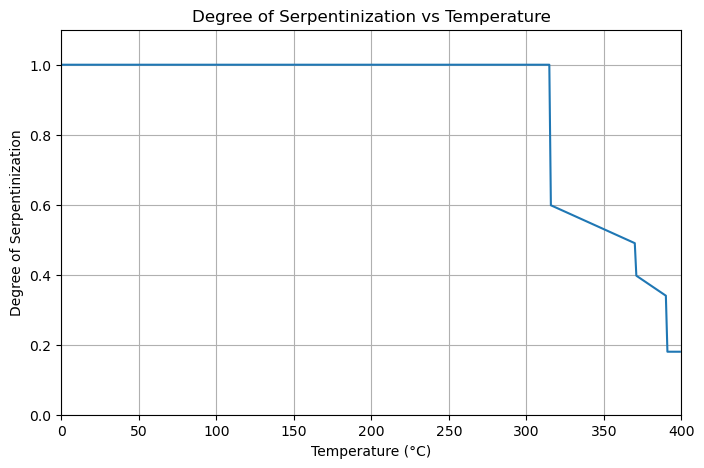

In [865]:
temp_examples = np.linspace(0, 400, 400)
func = np.piecewise(
    temp_examples,
    [
        temp_examples < 315,
        (temp_examples >= 315) & (temp_examples < 370),
        (temp_examples >= 370) & (temp_examples < 390),
        (temp_examples >= 390) & (temp_examples < 400),
        temp_examples >= 400
    ],
    [
        1,
        lambda x: -0.002 * x + 1.23,
        lambda x: -0.003 * x + 1.51,
        0.18,
        np.nan
    ]
)
plt.figure(figsize=(8, 5))
plt.plot(temp_examples, func, label= '')
plt.xlabel('Temperature (°C)')
plt.ylabel('Degree of Serpentinization')
plt.title('Degree of Serpentinization vs Temperature')
plt.xlim(0, 400)
plt.ylim(0, 1.1)  
plt.grid(True)
plt.show()

In [866]:

x2 = geophysical_data['x'].values
y2= geophysical_data['z'].values
x2_unique = np.unique(x2)
y2_unique = np.unique(y2)
X2, Y2 = np.meshgrid(x_unique, y_unique)
Z3 = np.empty(X.shape)
Z3[:] = np.nan
temps = geophysical_data['temp'].values
## Calculating equilibrium serpentinization % based on temperature
alteration = np.piecewise(
    temps,
    [
        temps < 315,
        (temps >= 315) & (temps < 370),
        (temps >= 370) & (temps < 390),
        (temps >= 390) & (temps < 400),
        temps >= 400
    ],
    [
        1,
        lambda x: -0.002 * x + 1.23,
        lambda x: -0.003 * x + 1.51,
        0.18,
        np.nan
    ]
)
geophysical_data['max_alteration'] = alteration
geophysical_data['alteration_percent'] = geophysical_data['Serp_Degree'] / geophysical_data['max_alteration']*100
geophysical_data['alteration_percent'] = geophysical_data['alteration_percent'].clip(0, 100) 
values3 = geophysical_data['alteration_percent'].values
for i in range(len(x2)):
    x_index = np.where(x2_unique == x2[i])[0][0]
    y_index = np.where(y2_unique == y2[i])[0][0]
    Z3[y_index, x_index] = values3[i]

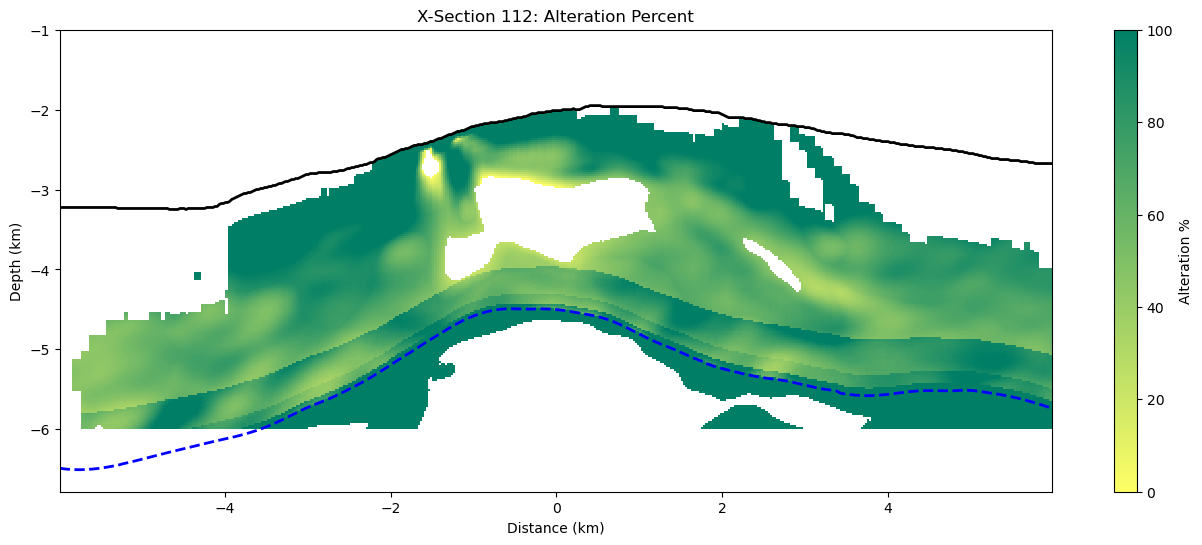

In [867]:
plt.figure(figsize=(16, 6))
im =plt.imshow(Z3, cmap ='summer_r',extent=[x_unique.min(), x_unique.max(), y_unique.min(), y_unique.max()], origin='lower', aspect='auto', interpolation='nearest')
plt.colorbar(label='Alteration %')  
plt.plot(locations['x'],locations['bathymetry'], color='black', linewidth=2, label='Bathymetry')  
plt.xlabel('Distance (km)')
plt.ylabel('Depth (km)')
plt.title('X-Section 112: Alteration Percent') 
plt.plot(contour_full['x'], contour_full['high_Vp'], color='blue', linestyle = '--', linewidth=2, label='Vp = 7 km/s') 
plt.show()